## Time series forecasting using RNN
This is an attempt to time series forecasting using Recurrent Neural Networks (RNNs). The model will attempt to forecast a univariate time series.


##Setting Up the Environment
Importing required libraries to build the Model. Each library has specific methods that we can use in building our model. Libraries are useful for faster implementation and also reduce cognitive load (no need to remember lots of information like weight matrices, variables and large no. of functions.)

In [ ]:
#<<---Click the play button Here
#You'll have to execute each code snippet in th sequence using the run/play button on the left. 
#Google Tensorflow API for Recursive Neural Network implentation
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
#Matplotlib is used to plot graphs
import matplotlib as mpl
import matplotlib.pyplot as plt
#Numpy is used for vector/matrix operations
import numpy as np
#Pandas is used to load and manage datasets
import pandas as pd
#Matplotlib Plot Attributes Global Declaration - Size of plots & Grid Display 
mpl.rcParams['figure.figsize'] = (14, 12)
mpl.rcParams['axes.grid'] = False

## Dataset Information: The Arc Welding Machines & More Producer Price Index (United States)

The Producer Price Index (U.S.) of Producer Price Index by Industry: Welding and Soldering Equipment Manufacturing: Arc Welding Machines, Components, and Accessories (Except Electrodes), Excluding Stud Welding Equipment dataset is available on <a href="https://fred.stlouisfed.org/series/PCU3339923339921">Federal Reserve Bank of St. Louis Website.</a>


**Units:**  Index Dec 1984=100, Not Seasonally Adjusted

**Frequency:**  Monthly

**Suggested Citation:**
U.S. Bureau of Labor Statistics, Producer Price Index by Industry: Welding and Soldering Equipment Manufacturing: Arc Welding Machines, Components, and Accessories (Except Electrodes), Excluding Stud Welding Equipment [PCU3339923339921], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/PCU3339923339921, May 9, 2020.

**Data Range:** 1973-01-01 to 2020-03-01 (567 Rows x 2 Coloumns)

**Coloumns:**
  1. Date (DD-MM-YYYY)
  2. Price Index (float_32)

The dataset is available on the above mentioned link and is in public license.

In [ ]:
#The code below will prompt you to upload a dataset file. I have attached the file in the mail itself. You can download the file and upload it after executing.

In [ ]:
#Upload the dataset file for use
from google.colab import files
uploaded = files.upload()

In [ ]:
#Loading Dataset using Pandas (pd)
df = pd.read_csv('/content/Arc Welding Machines, Components, and Accessories (Except Electrodes), Excluding Stud Welding Equipment US PPI.csv')

Let's take a glance at the data.

In [ ]:
df

,DATE,price,US,China
0,01-01-1973,46.0,56.0,57.0
1,01-02-1973,46.0,49.0,50.0
2,01-03-1973,46.0,47.0,53.0
3,01-04-1973,46.0,51.0,53.0
4,01-05-1973,46.0,50.2,53.2
...,...,...,...,...
559,01-08-2019,284.1,286.1,292.1
560,01-09-2019,284.1,289.1,292.1
561,01-10-2019,284.1,290.0,300.0
562,01-11-2019,284.0,288.0,292.0


##Creating training Data:
Given a specific date, let's say you want to predict the price 10 days in the future. In order to make this prediction, you choose to use 10 days of past  observations. Thus, you would create a window containing the last 10 day observations to train the model. Many such configurations are possible and we can vary window size to experiment.

The function below returns the above described windows of time for the model to train on. The parameter `history_size` is the size of the past window of information. The `target_size` is how far in the future does the model need to learn to predict. The `target_size` is the label that needs to be predicted.

In [ ]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

The first 400 rows of the data will be the training dataset, and the remaining will be the validation dataset. This amounts to 67 rows of training data.

In [ ]:
TRAIN_SPLIT = 456

Setting seed to ensure reproducibility.

In [ ]:
tf.random.set_seed(13)


First, We will train a model using Price, and use it to make predictions for the future.

Let's first extract the price from the dataset.

In [ ]:
uni_data = df['price']
uni_data.index = df['DATE']

uni_data_c = df['China']
uni_data_c.index = df['DATE']


In [ ]:
uni_data.head()

DATE
01-01-1973    46.0
01-02-1973    46.0
01-03-1973    46.0
01-04-1973    46.0
01-05-1973    46.0
Name: price, dtype: float64

Let's observe how this data looks across time.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f27ef322d68>],
      dtype=object)

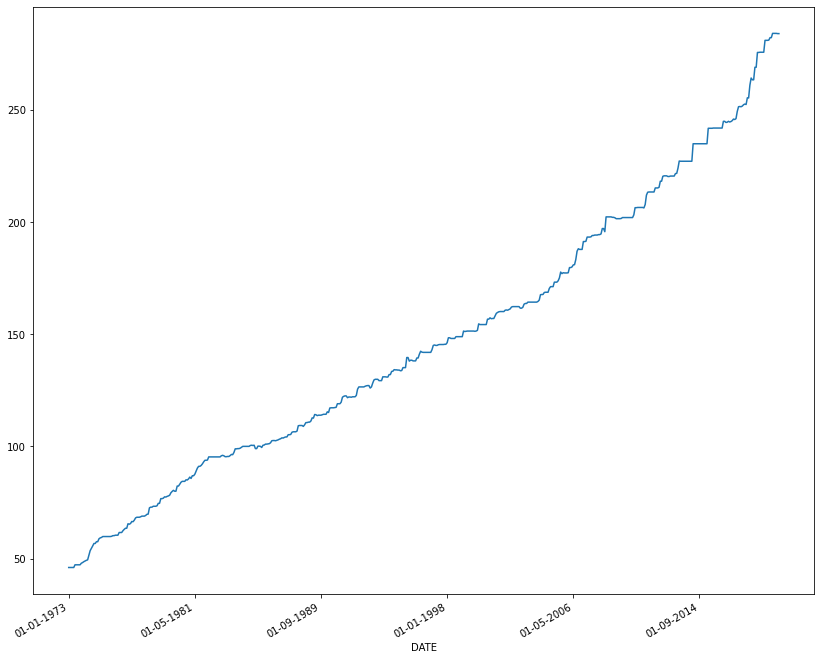

In [ ]:
uni_data.plot(subplots=True)

In [ ]:
uni_data = uni_data.values

In [ ]:
print(uni_data.shape)

(564,)


It is important to scale features before training a neural network. Standardization is a common way of doing this scaling by subtracting the mean and dividing by the standard deviation of each feature.You could also use a `tf.keras.utils.normalize` method that rescales the values into a range of [0,1].

Note: The mean and standard deviation should only be computed using the training data.

In [ ]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
print(uni_train_mean,uni_train_std)

124.97500000000001 43.71211580308663


Let's standardize the data.

In [ ]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [ ]:
print(uni_data)

[-1.80670733 -1.80670733 -1.80670733 -1.80670733 -1.80670733 -1.77925499
 -1.77925499 -1.77925499 -1.77925499 -1.77925499 -1.76324112 -1.75637803
 -1.74722725 -1.74036417 -1.73350108 -1.72892569 -1.68317179 -1.63513019
 -1.61225323 -1.58708858 -1.56192394 -1.56192394 -1.54362237 -1.54362237
 -1.51388234 -1.50473156 -1.50015616 -1.49100538 -1.49100538 -1.49100538
 -1.49100538 -1.49100538 -1.49100538 -1.49100538 -1.48871769 -1.4818546
 -1.4818546  -1.47727921 -1.47727921 -1.47727921 -1.44982687 -1.44982687
 -1.44982687 -1.43152531 -1.41779914 -1.40636066 -1.40636066 -1.36060675
 -1.36518214 -1.35831906 -1.3377298  -1.3400175  -1.32400363 -1.30112668
 -1.29426359 -1.29426359 -1.29426359 -1.2896882  -1.28282512 -1.28282512
 -1.28282512 -1.27596203 -1.26452355 -1.26223586 -1.19818039 -1.19131731
 -1.19131731 -1.18216652 -1.18216652 -1.18216652 -1.17759113 -1.15242649
 -1.15242649 -1.10438489 -1.10438489 -1.09980949 -1.08608332 -1.08837102
 -1.08150793 -1.07693254 -1.07006946 -1.04490481 -1.

Let's now create the data for the univariate model.The model will be given the last 5 recorded price observations, and needs to learn to predict the price at the next time step. 

In [ ]:
univariate_past_history = 10
univariate_future_target = 1

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

This is what the `univariate_data` function returns.

In [ ]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target Price to predict')
print (y_train_uni[0])

Single window of past history
[[-1.80670733]
 [-1.80670733]
 [-1.80670733]
 [-1.80670733]
 [-1.80670733]
 [-1.77925499]
 [-1.77925499]
 [-1.77925499]
 [-1.77925499]
 [-1.77925499]]

 Target Price to predict
-1.7563780336292647


##Now that the data has been created, let's take a look at a single example. The information given to the network is given in blue, and it must predict the value at the red cross.

In [ ]:
def create_time_steps(length):
  return list(range(-length, 0))

In [ ]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

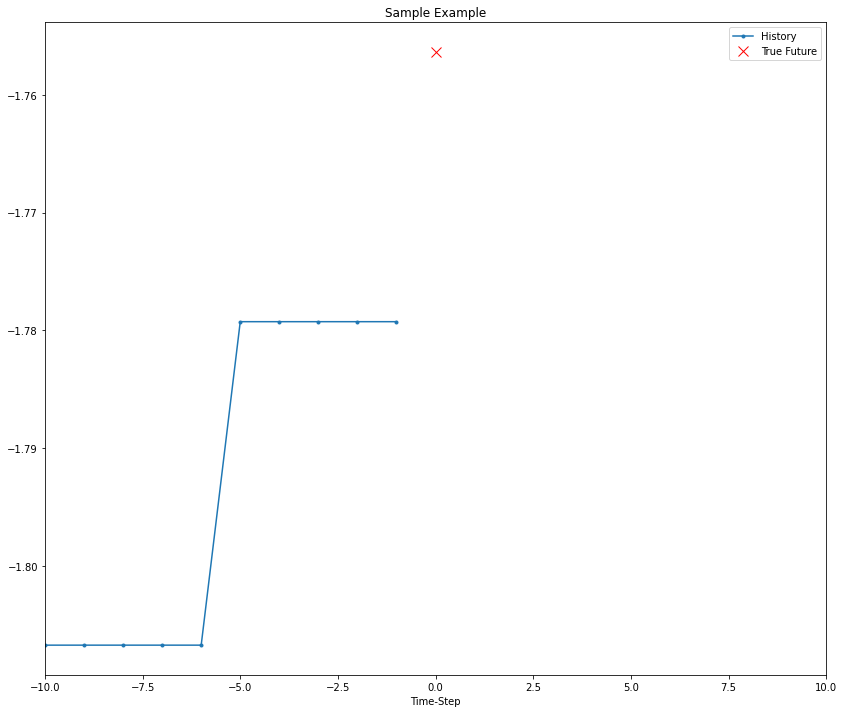

In [ ]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

## Baseline
Before proceeding to train a model, let's first set a simple baseline. Given an input point, the baseline method looks at all the history and predicts the next point to be the average of the last 20 observations.

In [ ]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

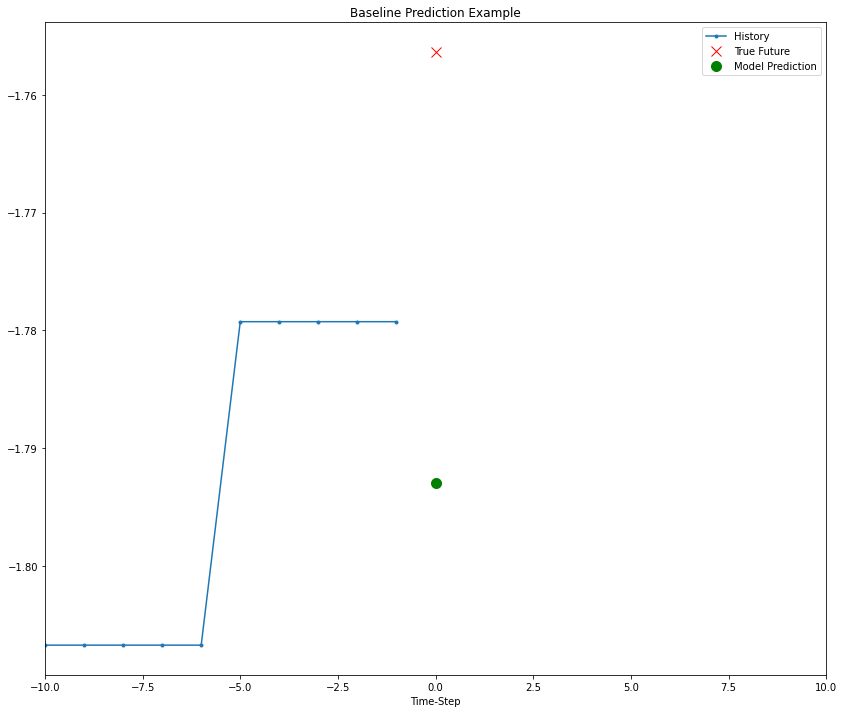

In [ ]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

Let's see if we can beat this baseline using a recurrent neural network.

## Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far. For more details, read the [RNN tutorial](https://www.tensorflow.org/tutorials/sequences/recurrent). In this tutorial, I have used a specialized RNN layer called Long Short Term Memory ([LSTM](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM))

Let's now use `tf.data` to shuffle, batch, and cache the dataset.

In [ ]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

The following visualisation should help you understand how the data is represented after batching.

![Time Series](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/time_series.png?raw=1)

## Defining the layers in the Model

In [ ]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(20, input_shape=x_train_uni.shape[-2:],return_sequences=True),

    tf.keras.layers.Dense(1)
])


simple_lstm_model.compile(optimizer='adam', loss='mae')

Let's make a sample prediction, to check the output of the model. 

In [ ]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(97, 10, 1)


##Let's train the model now. 
Note: The no. of epochs have varying impact on the training of the model.

In [ ]:
EVALUATION_INTERVAL = 500
EPOCHS = 5

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/5
500/500 [==============================] - 3s 6ms/step - loss: 0.1961 - val_loss: 0.3594
Epoch 2/5
500/500 [==============================] - 3s 6ms/step - loss: 0.0385 - val_loss: 0.2705
Epoch 3/5
500/500 [==============================] - 3s 6ms/step - loss: 0.0312 - val_loss: 0.3089
Epoch 4/5
500/500 [==============================] - 3s 6ms/step - loss: 0.0308 - val_loss: 0.3302
Epoch 5/5
500/500 [==============================] - 3s 6ms/step - loss: 0.0304 - val_loss: 0.3529


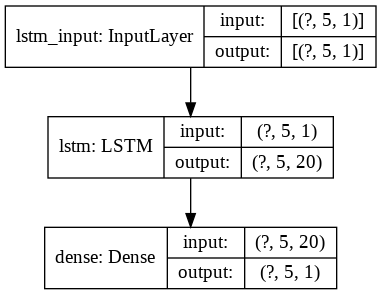

In [ ]:
tf.keras.utils.plot_model(simple_lstm_model, to_file="modelplot.png", show_shapes=True)

## Predictions using the LSTM model
Now that the LSTM model is trained, we can make predictions.

In [ ]:
#predict the future value for some window: 
for x, y in val_univariate.take(1):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

The above execution was for only one window. You may change the value of outcomes in the second line of above code snippet in the line:

"for x, y in val_univariate.take(1):" - gives output for one window.

"for x, y in val_univariate.take(10):" - gives output for ten windows.


In [ ]:
#We can then store results in an array:
x = simple_lstm_model.predict(val_univariate.take(1)).reshape(515)
print(x.shape) 

(515,)


In [ ]:
uni_data = (uni_data-uni_train_mean)/uni_train_std
print(uni_train_mean,uni_train_std)

124.97500000000001 43.71211580308663


##We need to denormalize the results to get the actual values 

In [ ]:
for i in range(len(x)):
  x[i] = (x[i]*uni_train_std)+uni_train_mean
print(x.shape)  

(515,)


In [ ]:
np.savetxt("RNNoutput.csv", x, delimiter=",")

##We can plot actual data and test data results to see the results of our model.

In [ ]:
mpl.rcParams['figure.figsize'] = (14, 12)
mpl.rcParams['axes.grid'] = False
uni_data = df['US']
uni_data.index = df['DATE']
x1 = uni_data.index
y1 = uni_data.values
x2 = uni_data.index[405:]
y2 = x[356:]
print(y2)

[238.23312 240.23651 243.64789 245.68483 236.51173 238.56454 242.66559
 245.15477 245.90918 236.77278 241.05081 244.18553 245.36446 246.00676
 238.82909 242.45401 244.26303 245.39621 246.26051 240.14793 242.38309
 244.21272 245.61566 246.68007 240.21011 242.29895 244.43944 246.04152
 246.90002 240.14793 242.53712 244.87897 246.26521 246.78998 240.33435
 242.9769  245.09422 246.14626 248.96019 240.70573 243.16438 244.94768
 248.32892 248.82578 240.89072 242.98988 247.16145 248.18787 252.9528
 240.76746 245.2839  247.03326 252.35846 255.05614 242.5936  244.99765
 251.15524 254.42908 254.76266 242.53352 249.2302  253.29288 254.1263
 255.02979 245.87393 251.14842 252.74945 254.28345 258.7084  247.67479
 250.35307 252.78918 257.95993 258.60907 247.22954 250.40872 256.59567
 257.87857 263.04306 247.22954 254.36542 256.52158 262.35828 263.03998
 250.27823 253.98851 260.87958 262.2573  263.40063 250.27823 258.47415
 260.80783 262.62018 263.49637 253.67203 258.0463  260.91608 262.59995
 263.491

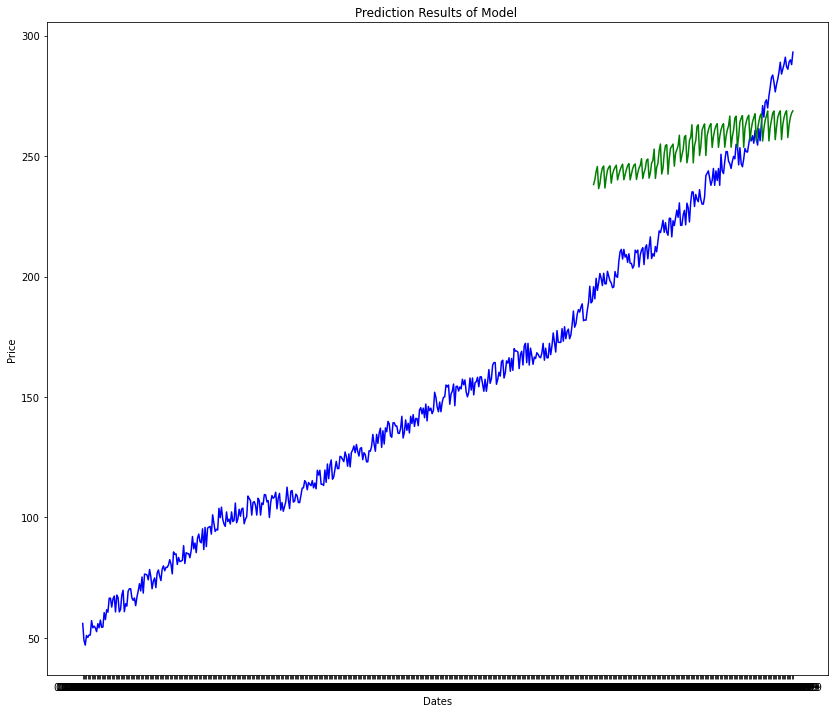

In [ ]:
plt.xlabel('Dates')
plt.ylabel('Price')
plt.title('Prediction Results of Model ')
plt.plot(x1, y1, 'b')
plt.plot(x2, y2, 'g')
plt.show()

## Next steps
After I complete the documentation, I will start studying to write a generator to yield data (instead of the uni/multivariate_data function), which would be more memory efficient along with [time series windowing optimization](https://www.tensorflow.org/guide/data#time_series_windowing) i.e. to optimize the window size so that we can get the best results.